# Introducão 


Este projeto faz parte do meu trabalho final para o curso de MBA de Data Science Analytics da instituição Usp-Esalq 


Os dados são referentes a dados de consultas do SUS marcados na cidade de Vitória - ES. O objetivo é fazer utilizar modelos de machine learning supervisionado para identificar a falta em consulta.

Para alcançar este objetivo, os dados usados estão disponíveis no kaggle https://www.kaggle.com/datasets/joniarroba/noshowappointments juntamente dos dados do INMET sobre a tempetura e dados de chuva para os dias em que as consultas são realizadas. 

Neste notebook, está o processo da engenharia e limpeza dos dados. 


## Bibliotecas

In [2]:
import pandas as pd 
import numpy as np 

import scipy.stats as stats
from datetime import datetime, timedelta

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv(r"C:\Users\afigueiredo\Downloads\MBA\TCC - MBA\Dados\Kaggle\KaggleV2-May-2016.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [9]:
print(f'Proporção de faltas: {df["No-show"].value_counts(normalize = True)[0]: .4f}')

Proporção de faltas:  0.7981


In [10]:
df['StatusFalta'] = df['No-show'].replace({'No':0, 'Yes':1})
df['StatusComparecimento'] = df['No-show'].replace({'No':'Compareceu', 'Yes':'Faltou'})

## Identificando consultas com mesmo ID

In [11]:
print(f"São {df.shape[0]} linhas e {df['AppointmentID'].nunique()} ids únicos")

São 110527 linhas e 110527 ids únicos


# Renomeando as variáveis

In [12]:
df.rename(columns = {'Gender':'Genero', 'ScheduledDay':'Agendamento',
       'AppointmentDay':'Consulta', 'Age':'Idade', 'Neighbourhood':'BairroUBS', 'Scholarship':'BolsaFamilia', 'Hipertension':'Hipertencao',
       'Alcoholism':'Alcoolatra', 'Handcap':'Deficiente'}, inplace = True)

In [13]:
df.head(2)

PatientId  AppointmentID Genero           Agendamento  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   

               Consulta  Idade        BairroUBS  BolsaFamilia  Hipertencao  \
0  2016-04-29T00:00:00Z     62  JARDIM DA PENHA             0            1   
1  2016-04-29T00:00:00Z     56  JARDIM DA PENHA             0            0   

   Diabetes  Alcoolatra  Deficiente  SMS_received No-show  StatusFalta  \
0         0           0           0             0      No            0   
1         0           0           0             0      No            0   

  StatusComparecimento  
0           Compareceu  
1           Compareceu

# Data Wrangling e limpeza dos dados 

In [14]:
df['DiaAgendamento'] = pd.to_datetime(list(map(lambda x : x[:10], df['Agendamento'])))
df['DiaConsulta'] =  pd.to_datetime(list(map(lambda x : x[:10], df['Consulta'])))

In [15]:
# Dia da semana da consulta

dia_semana = []

for j in range(0, len(df)):
    dia_semana.append(df['DiaConsulta'][j].strftime('%A'))
    
df['dia_semana'] = dia_semana

In [16]:
df['dia_semana'].replace({'Tuesday':'Ter', 'Monday':'Seg', 'Wednesday' : 'Qua', 
                          'Thursday': 'Qui', 'Friday':'Sex', 'Saturday':'Sab',
                          'Sunday':'Dom'}, inplace = True)

In [17]:
# tempo de espera 

marcacao = []
consulta = []
dif_dias = []

for j in range(0, len(df)):
    dA = datetime(year = df['DiaAgendamento'][j].year, month = df['DiaAgendamento'][j].month, day=df['DiaAgendamento'][j].day)
    dC= datetime(year = df['DiaConsulta'][j].year, month = df['DiaConsulta'][j].month, day=df['DiaConsulta'][j].day)
    dif_dias.append(dC - dA)

#dif_dias

In [18]:
df['TempoEspera'] =list(map(lambda d: d.days, dif_dias))

In [19]:
#Procurando se há tempo de espera negativo 

df[df['TempoEspera'] < 0]

PatientId  AppointmentID Genero           Agendamento  \
27033  7.839273e+12        5679978      M  2016-05-10T10:51:53Z   
55226  7.896294e+12        5715660      F  2016-05-18T14:50:41Z   
64175  2.425226e+13        5664962      F  2016-05-05T13:43:58Z   
71533  9.982316e+14        5686628      F  2016-05-11T13:49:20Z   
72362  3.787482e+12        5655637      M  2016-05-04T06:50:57Z   

                   Consulta  Idade      BairroUBS  BolsaFamilia  Hipertencao  \
27033  2016-05-09T00:00:00Z     38    RESISTÊNCIA             0            0   
55226  2016-05-17T00:00:00Z     19  SANTO ANTÔNIO             0            0   
64175  2016-05-04T00:00:00Z     22     CONSOLAÇÃO             0            0   
71533  2016-05-05T00:00:00Z     81  SANTO ANTÔNIO             0            0   
72362  2016-05-03T00:00:00Z      7     TABUAZEIRO             0            0   

       Diabetes  Alcoolatra  Deficiente  SMS_received No-show  StatusFalta  \
27033         0           0           1             0     Yes            1   
55226         0           0           1             0     Yes            1   
64175         0           0           0             0     Yes            1   
71533         0           0           0             0     Yes            1   
72362         0           0           0             0     Yes            1   

      StatusComparecimento DiaAgendamento DiaConsulta dia_semana  TempoEspera  
27033               Faltou     2016-05-10  2016-05-09        Seg           -1  
55226               Faltou     2016-05-18  2016-05-17        Ter           -1  
64175               Faltou     2016-05-05  2016-05-04        Qua           -1  
71533               Faltou     2016-05-11  2016-05-05        Qui           -6  
72362               Faltou     2016-05-04  2016-05-03        Ter           -1

In [20]:
print(f"Tempo de espera negativo corresponde a {df[df['TempoEspera'] < 0].shape[0]/df.shape[0]:.5f}% dos dados. Serão excluídos.")

Tempo de espera negativo corresponde a 0.00005% dos dados. Serão excluídos.


In [24]:
df = df[df['TempoEspera'] >= 0]

In [25]:
df['Feminimo'] = df['Genero'].replace({'M':0, 'F':1})

In [26]:
df[df['Idade'] < 0] #Será excluido

PatientId  AppointmentID Genero           Agendamento  \
99832  4.659432e+14        5775010      F  2016-06-06T08:58:13Z   

                   Consulta  Idade BairroUBS  BolsaFamilia  Hipertencao  \
99832  2016-06-06T00:00:00Z     -1     ROMÃO             0            0   

       Diabetes  ...  Deficiente  SMS_received  No-show StatusFalta  \
99832         0  ...           0             0       No           0   

       StatusComparecimento DiaAgendamento DiaConsulta dia_semana TempoEspera  \
99832            Compareceu     2016-06-06  2016-06-06        Seg           0   

       Feminimo  
99832         1  

[1 rows x 21 columns]

In [27]:
df = df[df['Idade'] >= 0].reset_index(drop = True)

In [28]:
df.shape

(110521, 21)

# Acrescentando dados do INMET

In [29]:
tempo = pd.read_csv(r"C:\Users\afigueiredo\Downloads\MBA\TCC - MBA\Dados\Tempo\INMET2016.csv",sep = ';', encoding = 'Latin')
tempo.head(2)

DATA (YYYY-MM-DD) HORA (UTC) PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0        01/01/2016      00:00                                0   
1        01/01/2016      01:00                                0   

  PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                               1012      
1                                             1012,4      

  PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                          1012,1   
1                                          1012,4   

  PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB) RADIACAO GLOBAL (KJ/m²)  \
0                                           1011,5                   -9999   
1                                             1012                   -9999   

  TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)  \
0                                         26,9   
1                                         26,8   

  TEMPERATURA DO PONTO DE ORVALHO (°C)  \
0                                 22,3   
1                                 21,9   

  TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
0                                       27,1   
1                                         27   

  TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  \
0                                       26,9   
1                                       26,8   

  TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)  \
0                                             22,4   
1                                             22,4   

  TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  \
0                                             22,1   
1                                             21,9   

   UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                        76   
1                                        76   

   UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                        75   
1                                        74   

   UMIDADE RELATIVA DO AR, HORARIA (%)  VENTO, DIREÇÃO HORARIA (gr) (° (gr))  \
0                                   76                                    28   
1                                   74                                     7   

  VENTO, RAJADA MAXIMA (m/s) VENTO, VELOCIDADE HORARIA (m/s)  
0                        7,4                               3  
1                        8,4                             2,9

In [30]:
tempo = tempo[['DATA (YYYY-MM-DD)', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
               'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
               'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)']]

In [31]:
tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   DATA (YYYY-MM-DD)                           8784 non-null   object
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)            8784 non-null   object
 2   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  8784 non-null   object
 3   TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  8784 non-null   object
dtypes: object(4)
memory usage: 274.6+ KB


In [32]:
#Transofrmando vírgula em pontos
colunas = tempo.columns

for col in colunas:
    tempo[col] = tempo[col].str.replace(',', '.')  

In [33]:
#Transformando as colunas numéricas em numéricas e data em data
for col in colunas[1:]:
    #print(col)
    tempo[col] = tempo[col].astype(float)
    
tempo['DATA (YYYY-MM-DD)'] = pd.to_datetime(tempo['DATA (YYYY-MM-DD)'])

C:\Users\afigueiredo\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/01/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\afigueiredo\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/01/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\afigueiredo\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/01/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\afigueiredo\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/01/2016' in DD/MM/YYYY format. 

In [34]:
tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   DATA (YYYY-MM-DD)                           8784 non-null   datetime64[ns]
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)            8784 non-null   float64       
 2   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  8784 non-null   float64       
 3   TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  8784 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 274.6 KB


In [35]:
#Fazendo as médias do dia
tempo = pd.DataFrame(tempo.groupby('DATA (YYYY-MM-DD)').mean()).reset_index()
tempo.head(2)

DATA (YYYY-MM-DD)  PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0        2016-01-01                               0.0   
1        2016-01-02                               0.0   

   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  \
0                                   29.554167   
1                                   28.229167   

   TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)  
0                                   28.558333  
1                                   27.329167

In [36]:
#Organizando nomes

tempo = tempo.rename({'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)' : 'PrecipitaçãoMediaAG',
                      'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)' : 'TempMaxAG',
                      'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)' : 'TempMinAG'}, axis = 1)

In [37]:
# Unindo os dados de tempo com os de falta

In [38]:
df = pd.merge(left = df, left_on = 'DiaConsulta', right = tempo, right_on = 'DATA (YYYY-MM-DD)').drop(columns = ['DATA (YYYY-MM-DD)'])

In [39]:
df.shape

(110521, 24)

In [40]:
#Criando a variável chuva - diferenete de 0 considerar choveu 

choveu = []
for i in range(0, df.shape[0]):
    if df['PrecipitaçãoMediaAG'][i] != 0:
        choveu.append(1)
    else:
        choveu.append(0)
        
        
df['Chuva'] = choveu

In [41]:
#Criando a variavel quantidade de doencas
qtd_doencas = []

selecao = df[['Hipertencao', 'Diabetes', 'Alcoolatra']]

for i in range(0, len(df)):
    qtd_doencas.append(selecao.iloc[i,:].sum())
    
df['Qtd_doencas'] = qtd_doencas

# Descritiva - EDA

In [42]:
print(f'São {df["PatientId"].nunique()} pacientes com {df["PatientId"].nunique()} consultas marcadas. Em {df["BairroUBS"].nunique()} bairros com unidades de Saúde. \
Destas consultas {df["StatusFalta"].sum()} são de faltas oque corresponde a {df["StatusFalta"].sum()/df.shape[0]:.3f}% dos dados')

São 62298 pacientes com 62298 consultas marcadas. Em 81 bairros com unidades de Saúde. Destas consultas 22314 são de faltas oque corresponde a 0.202% dos dados


In [43]:
#Faltas por unidade
aux_unit = (pd.DataFrame(df.groupby('StatusComparecimento')['BairroUBS'].value_counts())
                                    .rename(columns = {'BairroUBS':'qtd_registros'})
                                    .reset_index()
           )

df_comp =( aux_unit[aux_unit['StatusComparecimento'] == 'Compareceu']
                   .rename(columns = {'qtd_registros':'qtd_presenca'})
                
)

df_falt = (aux_unit[aux_unit['StatusComparecimento'] == 'Faltou']
                   .rename(columns = {'qtd_registros':'qtd_faltas'})
          )


df_aux = pd.merge(right = df_comp[['BairroUBS','qtd_presenca']], 
                  left = df_falt[['BairroUBS','qtd_faltas']], 
                  on = 'BairroUBS')

df_aux.sort_values("qtd_faltas", ascending = False)

BairroUBS  qtd_faltas  qtd_presenca
0      JARDIM CAMBURI        1465          6252
1         MARIA ORTIZ        1219          4586
2             ITARARÉ         923          2591
3         RESISTÊNCIA         905          3525
4              CENTRO         703          2631
..                ...         ...           ...
74  MORADA DE CAMBURI          16            80
75  PONTAL DE CAMBURI          12            57
76        ILHA DO BOI           3            32
77      ILHA DO FRADE           2             8
78          AEROPORTO           1             7

[79 rows x 3 columns]

In [35]:
unit = (pd.DataFrame(df["BairroUBS"].value_counts())
         .rename(columns = {'BairroUBS':'qtd_registros'})
         .reset_index()
         .rename({'index':'BairroUBS'}, axis =1))

unit['%registroConsultas'] = 100 *(unit['qtd_registros']/df.shape[0])

unit = pd.merge(right = unit, 
                  left = df_aux, 
                  on = 'BairroUBS')

unit['%presenca'] = unit['qtd_presenca']/unit['qtd_registros']
unit['%faltas'] = unit['qtd_faltas']/unit['qtd_registros']

unit.sort_values('%faltas', ascending = False)

BairroUBS  qtd_faltas  qtd_presenca  qtd_registros  \
24      SANTOS DUMONT         369           907           1276   
50      SANTA CECÍLIA         123           325            448   
48        SANTA CLARA         134           372            506   
2             ITARARÉ         923          2591           3514   
5   JESUS DE NAZARETH         696          2157           2853   
..                ...         ...           ...            ...   
68         DE LOURDES          47           258            305   
60       SOLON BORGES          69           400            469   
64     MÁRIO CYPRESTE          54           317            371   
78          AEROPORTO           1             7              8   
76        ILHA DO BOI           3            32             35   

    %registroConsultas  %presenca   %faltas  
24            1.154532   0.710815  0.289185  
50            0.405353   0.725446  0.274554  
48            0.457832   0.735178  0.264822  
2             3.179486   0.737336  0.262664  
5             2.581410   0.756046  0.243954  
..                 ...        ...       ...  
68            0.275966   0.845902  0.154098  
60            0.424354   0.852878  0.147122  
64            0.335683   0.854447  0.145553  
78            0.007238   0.875000  0.125000  
76            0.031668   0.914286  0.085714  

[79 rows x 7 columns]

In [44]:
#datas

print("           VISÃO GERAL SOBRE AS DATAS")

print(f"\n Menor data de agendamento {df['DiaAgendamento'].min()} \
      \n Maior data de agendemento {df['DiaAgendamento'].max()}")

print(f"\nMenor data de consulta {df['DiaConsulta'].min()} \
      \n Maior data de consulta {df['DiaConsulta'].max()}")



           VISÃO GERAL SOBRE AS DATAS

 Menor data de agendamento 2015-11-10 00:00:00       
 Maior data de agendemento 2016-06-08 00:00:00

Menor data de consulta 2016-04-29 00:00:00       
 Maior data de consulta 2016-06-08 00:00:00


In [45]:
pd.DataFrame(df['TempoEspera'].describe())

TempoEspera
count  110521.000000
mean       10.184345
std        15.255153
min         0.000000
25%         0.000000
50%         4.000000
75%        15.000000
max       179.000000

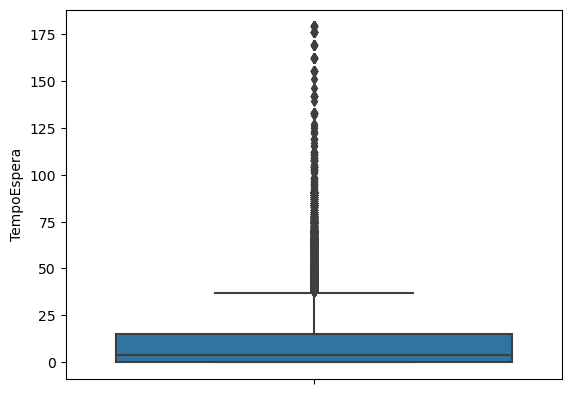

In [46]:
sns.boxplot(y = df['TempoEspera']);

In [49]:
print('                STATUS DADOS')
p1 = pd.DataFrame(df['StatusComparecimento'].value_counts())
p1['Proporcao'] = df['StatusComparecimento'].value_counts(normalize = True).values
p1.rename(columns = {'StatusComparecimento':'Contagem'})

                STATUS DADOS


Contagem  Proporcao
Compareceu     88207   0.798102
Faltou         22314   0.201898

### Pessoas

In [50]:
(f"São {df['PatientId'].nunique()} pacientes únicos")

'São 62298 pacientes únicos'

In [51]:
pessoas = df.drop_duplicates('PatientId')
pessoas.shape

(62298, 26)

In [52]:
p1 = pd.DataFrame(pessoas['Genero'].value_counts())
p1['Proporcao'] = pessoas['Genero'].value_counts(normalize = True).values
p1.rename(columns = {'Genero':'Contagem'})

Contagem  Proporcao
F     40045   0.642798
M     22253   0.357202

In [53]:
p1 = pd.DataFrame(pessoas['BolsaFamilia'].value_counts())
p1['Proporcao'] = pessoas['BolsaFamilia'].value_counts(normalize = True).values
p1.rename(columns = {'BolsaFamilia':'Contagem'}, 
         index = {0: 'Não Beneficiário', 
                  1: 'Beneficiário'})

Contagem  Proporcao
Não Beneficiário     56510   0.907092
Beneficiário          5788   0.092908

In [54]:
p1 = pd.DataFrame(pessoas['Diabetes'].value_counts())
p1['Proporcao'] = pessoas['Diabetes'].value_counts(normalize = True).values
p1.rename(columns = {'Diabetes':'Contagem'}, 
         index = {0: 'Não Diabético', 
                  1: 'Diabético'})

Contagem  Proporcao
Não Diabético     57882   0.929115
Diabético          4416   0.070885

In [55]:
p1 = pd.DataFrame(pessoas['Hipertencao'].value_counts())
p1['Proporcao'] = pessoas['Hipertencao'].value_counts(normalize = True).values
p1.rename(columns = {'Hipertencao':'Contagem'}, 
         index = {0: 'Não Hipertenso', 
                  1: 'Hipertenso'})

Contagem  Proporcao
Não Hipertenso     50056   0.803493
Hipertenso         12242   0.196507

In [56]:
p1 = pd.DataFrame(pessoas['Alcoolatra'].value_counts())
p1['Proporcao'] = pessoas['Alcoolatra'].value_counts(normalize = True).values
p1.rename(columns = {'Alcoolatra':'Contagem'}, 
         index = {0: 'Não Alcoolatra', 
                  1: 'Alcoolatra'})

Contagem  Proporcao
Não Alcoolatra     60792   0.975826
Alcoolatra          1506   0.024174

In [57]:
p1 = pd.DataFrame(pessoas['Deficiente'].replace({2:1,3:1, 4:1}).value_counts())
p1['Proporcao'] = pessoas['Deficiente'].replace({2:1,3:1, 4:1}).value_counts(normalize = True).values


p1.rename(columns = {'Deficiente':'Contagem'}, 
         index = {0: 'Não Deficiencia', 
                  1: 'Uma ou maisnDeficiencia'})

Contagem  Proporcao
Não Deficiencia             61165   0.981813
Uma ou maisnDeficiencia      1133   0.018187

In [58]:
#Porcentagem das doencas cronicas
cronicas = pessoas[['Hipertencao', 'Diabetes',    'Alcoolatra']]

qtd=[]
for i in range(len(cronicas)):
    qtd.append(cronicas.iloc[i,:].sum())
    
cronicas['Quantidade_DoencasCronicas'] = qtd

C:\Users\afigueiredo\AppData\Local\Temp\ipykernel_29164\1672412855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cronicas['Quantidade_DoencasCronicas'] = qtd


In [59]:
print('Quantidade de pessoas com uma ou mais doenças crônicas: ',cronicas['Quantidade_DoencasCronicas'].value_counts().values[1:].sum())
print(f"Valor percentual: { cronicas['Quantidade_DoencasCronicas'].value_counts(normalize = True).values[1:].sum()*100: .2f}%")

Quantidade de pessoas com uma ou mais doenças crônicas:  13945
Valor percentual:  22.38%


In [60]:
aux_doencas = (pd.DataFrame(df.groupby('StatusComparecimento')['Qtd_doencas']
                            .value_counts()).rename(columns={'Qtd_doencas':'Frequencia'})
                            .reset_index()
              )
 

aux_doencas

StatusComparecimento  Qtd_doencas  Frequencia
0           Compareceu            0       67473
1           Compareceu            1       14453
2           Compareceu            2        6071
3           Compareceu            3         210
4               Faltou            0       17833
5               Faltou            1        3129
6               Faltou            2        1306
7               Faltou            3          46

In [76]:
fig = px.bar(aux_doencas, x="StatusComparecimento",  y = 'Frequencia',color="Qtd_doencas", barmode="group", color_continuous_scale =px.colors.sequential.Viridis)
fig.show()

In [62]:
intervalos = [-1,17,29, 59,116]
nomes = ['Menor de idade', 'Entre 18 e 29 anos','Entre 30 e 59 anos' ,'60 anos ou mais']

pessoas['Faixa_Idade'] = pd.cut(pessoas['Idade'], bins = intervalos, labels=nomes)

C:\Users\afigueiredo\AppData\Local\Temp\ipykernel_29164\3934809557.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
aux_Idade = (pd.DataFrame(pessoas['Faixa_Idade'].value_counts())
                                           .rename({'Faixa_Idade':'qtd'}, axis = 1).reset_index()
                                           .rename({'index':'Faixas_Idade'}, axis = 1)
            )
aux_Idade

Faixas_Idade    qtd
0  Entre 30 e 59 anos  24506
1      Menor de idade  16259
2     60 anos ou mais  12180
3  Entre 18 e 29 anos   9353

In [66]:
fig = px.funnel_area(aux_Idade, values='qtd', names='Faixas_Idade', color_discrete_sequence =px.colors.sequential.Viridis )
fig

In [67]:
intervalos = [-1,17,29, 59,116]
nomes = ['Menor de idade', 'Entre 18 e 29 anos','Entre 30 e 59 anos' ,'60 anos ou mais']

df['Faixa_Idade'] = pd.cut(df['Idade'], bins = intervalos, labels=nomes)

In [68]:
idade = pd.crosstab(df['StatusComparecimento'], df['Faixa_Idade'], margins= True).reset_index()
idade

Faixa_Idade StatusComparecimento  Menor de idade  Entre 18 e 29 anos  \
0                     Compareceu           21382               12607   
1                         Faltou            5996                4122   
2                            All           27378               16729   

Faixa_Idade  Entre 30 e 59 anos  60 anos ou mais     All  
0                         36287            17931   88207  
1                          8955             3241   22314  
2                         45242            21172  110521

In [69]:
# Frequência de Falta por dia da semana


tab1 = pd.DataFrame(df.groupby('dia_semana')['StatusComparecimento'].value_counts()).rename(columns = {'StatusComparecimento':'QTD'}).reset_index()
tab1

dia_semana StatusComparecimento    QTD
0         Qua           Compareceu  20774
1         Qua               Faltou   5092
2         Qui           Compareceu  13909
3         Qui               Faltou   3337
4         Sab           Compareceu     30
5         Sab               Faltou      9
6         Seg           Compareceu  18024
7         Seg               Faltou   4689
8         Sex           Compareceu  14982
9         Sex               Faltou   4037
10        Ter           Compareceu  20488
11        Ter               Faltou   5150

In [70]:
print('  VALORES EM PORCENTAGEM GERAL')
comp = []
falt = []
for i in range(0, len(tab1)):
    print(f"\nDia {tab1['dia_semana'][i]} status {tab1['StatusComparecimento'][i]} : {100 * (tab1['QTD'][i]/len(df)):.2f}")
    if tab1['StatusComparecimento'][i] == 'Compareceu':
        comp.append(100 * (tab1['QTD'][i]/len(df)))
    else:
        falt.append(100 * (tab1['QTD'][i]/len(df)))

  VALORES EM PORCENTAGEM GERAL

Dia Qua status Compareceu : 18.80

Dia Qua status Faltou : 4.61

Dia Qui status Compareceu : 12.58

Dia Qui status Faltou : 3.02

Dia Sab status Compareceu : 0.03

Dia Sab status Faltou : 0.01

Dia Seg status Compareceu : 16.31

Dia Seg status Faltou : 4.24

Dia Sex status Compareceu : 13.56

Dia Sex status Faltou : 3.65

Dia Ter status Compareceu : 18.54

Dia Ter status Faltou : 4.66


In [71]:
print(f'Soma das porcentagens: {sum(comp) + sum(falt)}, \
    \nSoma compareceu: {sum(comp)} \ \nSoma faltou: {sum(falt)}')

Soma das porcentagens: 100.0,     
Soma compareceu: 79.81017182254956 \ 
Soma faltou: 20.18982817745044


In [72]:
df.groupby('StatusComparecimento')['TempoEspera'].describe()

count       mean       std  min  25%   50%   75%  \
StatusComparecimento                                                       
Compareceu            88207.0   8.754759  14.55045  0.0  0.0   2.0  12.0   
Faltou                22314.0  15.835484  16.60560  0.0  4.0  11.0  23.0   

                        max  
StatusComparecimento         
Compareceu            179.0  
Faltou                179.0

In [73]:
#Tempo até consulta por dia da semana
fig = px.box(df, y ="TempoEspera", color="StatusComparecimento",
            labels = {"TempoEspera":"Tempo em Dias", "dia_agendamento":"", "StatusComparecimento":"Status"},
            color_discrete_sequence =px.colors.sequential.Viridis)
fig.show()

In [63]:
df.groupby('StatusComparecimento')[['TempoEspera', 'Qtd_doencas']].describe()

TempoEspera                                             \
                           count       mean       std  min  25%   50%   75%   
StatusComparecimento                                                          
Compareceu               88207.0   8.754759  14.55045  0.0  0.0   2.0  12.0   
Faltou                   22314.0  15.835484  16.60560  0.0  4.0  11.0  23.0   

                            Qtd_doencas                                     \
                        max       count      mean       std  min  25%  50%   
StatusComparecimento                                                         
Compareceu            179.0     88207.0  0.308649  0.604423  0.0  0.0  0.0   
Faltou                179.0     22314.0  0.263467  0.568764  0.0  0.0  0.0   

                                
                      75%  max  
StatusComparecimento            
Compareceu            0.0  3.0  
Faltou                0.0  3.0

In [64]:
pd.set_option('display.max_rows', 200)

print( '                Proporção de faltas por dia da semana')

prop_faltas = (pd.DataFrame(df.groupby('dia_semana')['StatusComparecimento'].value_counts())
                .rename(columns={'StatusComparecimento':'Qtd'}).reset_index()
)



aux = pd.DataFrame(df.groupby('dia_semana')['TempoEspera'].count()).reset_index().rename(columns = {'TempoEspera':'Total'})

prop_faltas = pd.merge(prop_faltas,aux)
prop_faltas

proporcao = []
for i in range(0, len(prop_faltas)):
    proporcao.append(prop_faltas['Qtd'][i]/prop_faltas['Total'][i])

prop_faltas['Prop'] = proporcao
prop_faltas

                Proporção de faltas por dia da semana


dia_semana StatusComparecimento    Qtd  Total      Prop
0         Qua           Compareceu  20774  25866  0.803139
1         Qua               Faltou   5092  25866  0.196861
2         Qui           Compareceu  13909  17246  0.806506
3         Qui               Faltou   3337  17246  0.193494
4         Sab           Compareceu     30     39  0.769231
5         Sab               Faltou      9     39  0.230769
6         Seg           Compareceu  18024  22713  0.793554
7         Seg               Faltou   4689  22713  0.206446
8         Sex           Compareceu  14982  19019  0.787739
9         Sex               Faltou   4037  19019  0.212261
10        Ter           Compareceu  20488  25638  0.799126
11        Ter               Faltou   5150  25638  0.200874

In [65]:
pd.set_option('display.max_rows', 200)

print( '                Proporção de faltas por unidade de Saúde')

prop_faltas = (pd.DataFrame(df.groupby('BairroUBS')['StatusComparecimento'].value_counts())
                .rename(columns={'StatusComparecimento':'Qtd'}).reset_index()
)

aux = pd.DataFrame(df.groupby('BairroUBS')['TempoEspera'].count()).reset_index().rename(columns = {'TempoEspera':'Total'})
prop_faltas = pd.merge(prop_faltas,aux)


proporcao = []
for i in range(0, len(prop_faltas)):
    proporcao.append(prop_faltas['Qtd'][i]/prop_faltas['Total'][i])

prop_faltas['Prop'] = proporcao
prop_faltas

                Proporção de faltas por unidade de Saúde


BairroUBS StatusComparecimento   Qtd  Total      Prop
0                      AEROPORTO           Compareceu     7      8  0.875000
1                      AEROPORTO               Faltou     1      8  0.125000
2                     ANDORINHAS           Compareceu  1741   2262  0.769673
3                     ANDORINHAS               Faltou   521   2262  0.230327
4                ANTÔNIO HONÓRIO           Compareceu   221    271  0.815498
5                ANTÔNIO HONÓRIO               Faltou    50    271  0.184502
6            ARIOVALDO FAVALESSA           Compareceu   220    282  0.780142
7            ARIOVALDO FAVALESSA               Faltou    62    282  0.219858
8                 BARRO VERMELHO           Compareceu   332    423  0.784870
9                 BARRO VERMELHO               Faltou    91    423  0.215130
10                    BELA VISTA           Compareceu  1523   1907  0.798637
11                    BELA VISTA               Faltou   384   1907  0.201363
12                BENTO FERREIRA           Compareceu   665    858  0.775058
13                BENTO FERREIRA               Faltou   193    858  0.224942
14                     BOA VISTA           Compareceu   254    312  0.814103
15                     BOA VISTA               Faltou    58    312  0.185897
16                        BONFIM           Compareceu  2223   2773  0.801659
17                        BONFIM               Faltou   550   2773  0.198341
18                     CARATOÍRA           Compareceu  1974   2565  0.769591
19                     CARATOÍRA               Faltou   591   2565  0.230409
20                        CENTRO           Compareceu  2631   3334  0.789142
21                        CENTRO               Faltou   703   3334  0.210858
22                       COMDUSA           Compareceu   254    310  0.819355
23                       COMDUSA               Faltou    56    310  0.180645
24                     CONQUISTA           Compareceu   689    849  0.811543
25                     CONQUISTA               Faltou   160    849  0.188457
26                    CONSOLAÇÃO           Compareceu  1139   1375  0.828364
27                    CONSOLAÇÃO               Faltou   236   1375  0.171636
28                    CRUZAMENTO           Compareceu  1094   1398  0.782546
29                    CRUZAMENTO               Faltou   304   1398  0.217454
30                      DA PENHA           Compareceu  1788   2217  0.806495
31                      DA PENHA               Faltou   429   2217  0.193505
32                    DE LOURDES           Compareceu   258    305  0.845902
33                    DE LOURDES               Faltou    47    305  0.154098
34                     DO CABRAL           Compareceu   472    560  0.842857
35                     DO CABRAL               Faltou    88    560  0.157143
36                    DO MOSCOSO           Compareceu   321    413  0.777240
37                    DO MOSCOSO               Faltou    92    413  0.222760
38                     DO QUADRO           Compareceu   709    849  0.835100
39                     DO QUADRO               Faltou   140    849  0.164900
40                ENSEADA DO SUÁ           Compareceu   183    235  0.778723
41                ENSEADA DO SUÁ               Faltou    52    235  0.221277
42                    ESTRELINHA           Compareceu   432    538  0.802974
43                    ESTRELINHA               Faltou   106    538  0.197026
44                  FONTE GRANDE           Compareceu   533    682  0.781525
45                  FONTE GRANDE               Faltou   149    682  0.218475
46                FORTE SÃO JOÃO           Compareceu  1543   1889  0.816834
47                FORTE SÃO JOÃO               Faltou   346   1889  0.183166
48                     FRADINHOS           Compareceu   210    258  0.813953
49                     FRADINHOS               Faltou    48    258  0.186047
50                    GOIABEIRAS           Compareceu   563    700  0.804286
51                 

In [66]:
prop_faltas[prop_faltas['StatusComparecimento'] == 'Faltou']['Prop'].describe() #Talvez seja interessante rer uma variavel para indicar a unidade de saúde 

count    80.000000
mean      0.207975
std       0.095045
min       0.085714
25%       0.180461
50%       0.197650
75%       0.217709
max       1.000000
Name: Prop, dtype: float64

# Tempo até consulta por dia da semana
fig = px.box(df, y ="TempoAteConsulta", x = "dia_agendamento", color="StatusComparecimento",
            labels = {"TempoAteConsulta":"Dias até consulta", "dia_agendamento":"", "StatusComparecimento":"Status"})
fig.show()

In [67]:
df.groupby('StatusComparecimento')['TempoEspera'].describe()

count       mean       std  min  25%   50%   75%  \
StatusComparecimento                                                       
Compareceu            88207.0   8.754759  14.55045  0.0  0.0   2.0  12.0   
Faltou                22314.0  15.835484  16.60560  0.0  4.0  11.0  23.0   

                        max  
StatusComparecimento         
Compareceu            179.0  
Faltou                179.0

## Relação entre as variáveis 

In [78]:
sms = pd.crosstab(df['StatusComparecimento'],df['SMS_received'])
sms

SMS_received              0      1
StatusComparecimento              
Compareceu            62509  25698
Faltou                12530   9784

In [95]:
chi2, p, dof, expected = stats.chi2_contingency(sms)

print(f'Com o p-valor de {p} com o nível de significância de 5% há evidências para rejeitar H0, ou seja, há associoção entre as variáveis') # Rejeita H0 -> Há associação entre as variáveis 

Com o p-valor de 0.0 com o nível de significância de 5% há evidências para rejeitar H0, ou seja, há associoção entre as variáveis


In [85]:
#Vamos ver o medida de Cramer's  V p/ quantificar a relação entre as variáveis.

def cramersV(quiquadrado, n, r,s):
    num = quiquadrado/n
    den = min(r-1, s-1)
    funcao = np.sqrt(num/den)
    return(funcao)

In [93]:
print(f"Para quantificar a relação existente entre as variáveis foi utilizado a medida de Cramer's V. \n\
O valor dado foi de {cramersV(chi2,n=df.shape[0], r = 2, s = 2):.2f} o que indica uma realçao fraca.")

Para quantificar a relação existente entre as variáveis foi utilizado a medida de Cramer's V. 
O valor dado foi de 0.13 o que indica uma realçao fraca.


In [94]:
chuva = pd.crosstab(df['Chuva'], df['StatusComparecimento'])
chuva

StatusComparecimento  Compareceu  Faltou
Chuva                                   
0                          58419   14756
1                          29788    7558

In [106]:
chi2_chuva, p, dof, expected = stats.chi2_contingency(chuva)

print('p-valor:',round(p,2), '\n\
Para nível de confiança de 95% não é possível rejeitar a hipótese nula, ou seja, as variáveis não possuem uma relação,\nsão independentes. ')

p-valor: 0.78 
Para nível de confiança de 95% não é possível rejeitar a hipótese nula, ou seja, as variáveis não possuem uma relação,
são independentes. 


### Temperatura será que interfere ??

In [107]:
temperatura = df.groupby(['DiaConsulta','StatusComparecimento']).agg({'TempMaxAG':min, 'TempMinAG':max}).reset_index()
temperatura['TempMedia'] = (temperatura['TempMaxAG'] + temperatura['TempMinAG'])/2

temperatura

DiaConsulta StatusComparecimento  TempMaxAG  TempMinAG  TempMedia
0   2016-04-29           Compareceu  22.866667  22.529167  22.697917
1   2016-04-29               Faltou  22.866667  22.529167  22.697917
2   2016-05-02           Compareceu  27.970833  26.987500  27.479167
3   2016-05-02               Faltou  27.970833  26.987500  27.479167
4   2016-05-03           Compareceu  27.416667  26.500000  26.958333
5   2016-05-03               Faltou  27.416667  26.500000  26.958333
6   2016-05-04           Compareceu  27.066667  26.258333  26.662500
7   2016-05-04               Faltou  27.066667  26.258333  26.662500
8   2016-05-05           Compareceu  24.579167  23.629167  24.104167
9   2016-05-05               Faltou  24.579167  23.629167  24.104167
10  2016-05-06           Compareceu  26.045833  25.150000  25.597917
11  2016-05-06               Faltou  26.045833  25.150000  25.597917
12  2016-05-09           Compareceu  24.029167  23.054167  23.541667
13  2016-05-09               Faltou  24.029167  23.054167  23.541667
14  2016-05-10           Compareceu  23.045833  22.379167  22.712500
15  2016-05-10               Faltou  23.045833  22.379167  22.712500
16  2016-05-11           Compareceu  25.329167  24.662500  24.995833
17  2016-05-11               Faltou  25.329167  24.662500  24.995833
18  2016-05-12           Compareceu  26.158333  25.483333  25.820833
19  2016-05-12               Faltou  26.158333  25.483333  25.820833
20  2016-05-13           Compareceu  24.262500  23.587500  23.925000
21  2016-05-13               Faltou  24.262500  23.587500  23.925000
22  2016-05-14           Compareceu  23.750000  23.154167  23.452083
23  2016-05-14               Faltou  23.750000  23.154167  23.452083
24  2016-05-16           Compareceu  25.237500  24.166667  24.702083
25  2016-05-16               Faltou  25.237500  24.166667  24.702083
26  2016-05-17           Compareceu  25.379167  24.495833  24.937500
27  2016-05-17               Faltou  25.379167  24.495833  24.937500
28  2016-05-18           Compareceu  25.112500  24.287500  24.700000
29  2016-05-18               Faltou  25.112500  24.287500  24.700000
30  2016-05-19           Compareceu  24.366667  23.820833  24.093750
31  2016-05-19               Faltou  24.366667  23.820833  24.093750
32  2016-05-20           Compareceu  24.862500  24.316667  24.589583
33  2016-05-20               Faltou  24.862500  24.316667  24.589583
34  2016-05-24           Compareceu  23.083333  22.529167  22.806250
35  2016-05-24               Faltou  23.083333  22.529167  22.806250
36  2016-05-25           Compareceu  23.379167  22.741667  23.060417
37  2016-05-25               Faltou  23.379167  22.741667  23.060417
38  2016-05-30           Compareceu  24.387500  23.254167  23.820833
39  2016-05-30               Faltou  24.387500  23.254167  23.820833
40  2016-05-31           Compareceu  24.712500  23.666667  24.189583
41  2016-05-31               Faltou  24.712500  23.666667  24.189583
42  2016-06-01           Compareceu  25.820833  24.941667  25.381250
43  2016-06-01               Faltou  25.820833  24.941667  25.381250
44  2016-06-02           Compareceu  28.712500  27.720833  28.216667
45  2016-06-02               Faltou  28.712500  27.720833  28.216667
46  2016-06-03           Compareceu  29.116667  28.212500  28.664583
47  2016-06-03               Faltou  29.116667  28.212500  28.664583
48  2016-06-06           Compareceu  26.850000  25.845833  26.347917
49  2016-06-06               Faltou  26.850000  25.845833  26.347917
50  2016-06-07           Compareceu  23.000000  22.066667  22.533333
51  2016-06-07               Faltou  23.000000  22.066667  22.533333
52  2016-06-08           Compareceu  22.750000  21.708333  22.229167
53  2016-06-08               Faltou  22.750000  21.708333  22.229167

In [108]:
px.box(data_frame = df,  y = 'TempMaxAG' , color = 'StatusComparecimento')

In [109]:
pd.DataFrame(df.groupby('StatusComparecimento')['Qtd_doencas'].value_counts()).rename(columns = {'Qtd_doencas':'Frequencia'})#.reset_index()

Frequencia
StatusComparecimento Qtd_doencas            
Compareceu           0                 67473
                     1                 14453
                     2                  6071
                     3                   210
Faltou               0                 17833
                     1                  3129
                     2                  1306
                     3                    46

In [110]:
df.to_csv(r'C:\Users\afigueiredo\Downloads\MBA\TCC - MBA\Dados\Kaggle\modelar.csv', sep = ';', index = False)